In [25]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
import math
from agents import *
from numba import njit
from time import perf_counter

In [18]:
class Arbiter:
    '''
    Manage running tournament. Base class. 
    Inherited, inheriting class defines how games are decided.
    Inheriting class also decides how the agent array is created. Agent array needs to be created at initialization
    '''
    def manageTournament(self, Nrounds):
        for _ in range(Nrounds):
            self.manageRound(self.generateRound())

    def manageRound(self, games):
        '''
        games: Array of 2-long arrays of matchups
        scores array: row is agent, column is opponent
        '''
        scores = np.zeros((len(self.agents),len(self.agents)))
        for game in games:
            a1, a2 = game[0], game[1]
            a1score, a2score = playNIterations(self.agents[a1],self.agents[a2], self.iters)
            scores[game[0], game[1]] += a1score
            scores[game[1], game[0]] += a2score
        self.score += scores

In [19]:
class NetworkArbiter(Arbiter):
    '''
    For managing network based interaction. Adjacency table is 2d
    '''
    def __init__(self, iterations, agents):
        self.iters = iterations # integer
        self.agents = agents # 1d list of agents
        self.score = np.zeros((len(self.agents), len(self.agents)))
    
    def constructTable(self):
        '''
        Builds adjacency table by generating random probability vectors for each agent
        '''
        N = len(self.agents)
        adjMat = (np.ones((N,N)) - np.eye(N)) / (N-1)
        for n in range(N): # Probablity of interacting with every other agent
            randomVec = random.rand(N - 1)
            probVec = randomVec / np.sum(randomVec)
            adjMat[0:n,n] = probVec[:n]
            adjMat[n+1:,n] = probVec[n:]
        self.adjMat = adjMat

    def generateRound(self):
        playersLeft = set(range(len(self.agents))) # Players 0-n set
        playersSeen = set()
        games = []
        adjMat = self.adjMat # Copied because table is adjusted
        while len(playersLeft) > 1:
            # Choose first agent and track that agent has been seen
            player = random.choice(list(playersLeft))
            playersLeft.remove(player)
            playersSeen.add(player)
            # First agent interaction weights.
            # Set probability of interacting with already taken agents to 0
            weights = np.delete(adjMat[:,player], list(playersSeen))
            weights /= np.sum(weights)
            # Choose opponent
            opponent = random.choice(list(playersLeft), p=weights)
            playersLeft.remove(opponent)
            playersSeen.add(opponent)
            games.append(np.array([player, opponent]))
        return games

    def displayScores(self):
        plt.imshow(self.score, cmap = 'YlOrRd')

    def displayAdjMat(self):
        np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
        display(self.adjMat)

array([[0.000, 0.177, 0.299, 0.117, 0.149, 0.130, 0.156, 0.118],
       [0.079, 0.000, 0.270, 0.275, 0.068, 0.142, 0.055, 0.046],
       [0.288, 0.141, 0.000, 0.084, 0.184, 0.255, 0.195, 0.183],
       [0.025, 0.069, 0.077, 0.000, 0.007, 0.132, 0.163, 0.198],
       [0.175, 0.001, 0.198, 0.140, 0.000, 0.065, 0.208, 0.191],
       [0.052, 0.102, 0.029, 0.251, 0.236, 0.000, 0.126, 0.216],
       [0.089, 0.274, 0.043, 0.051, 0.245, 0.141, 0.000, 0.048],
       [0.292, 0.236, 0.083, 0.083, 0.111, 0.134, 0.097, 0.000]])

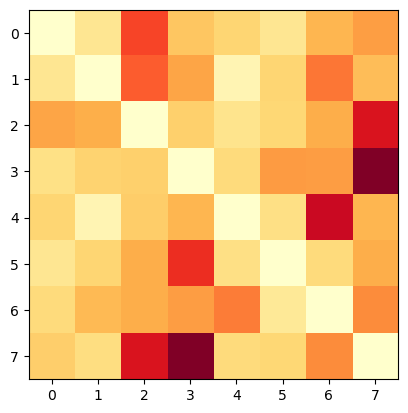

In [20]:
net = NetworkArbiter(10, [Du(), Du(), TFT(), TFT(), Du(), Du(), TFT(), TFT()])
net.constructTable()
net.manageTournament(100)
#net.scores = net.score / net.adjMat
net.displayAdjMat()
net.displayScores()

In [35]:
class GridArbiter(Arbiter):
    '''
    For managing grid based tournaments
    '''
    def __init__(self, iterations, agents, error=None):
        self.iters = iterations
        self.agents = agents # 2d grid of agents
        self.score = np.zeros(agents.shape)
        self.buildAdjMat()
        self.error = error

    def buildAdjMat(self):
        '''
        Creates a 4d adjacency table. two of the dimensions represent the agents,
        and each cell in these two dimensions holds a 2d adjacency grid holding 
        their interactions with the rest of the agents
        '''
        start = perf_counter()
        N = len(self.agents)
        adjacencies = []
        for idr, row in enumerate(self.agents):
            entry = []
            for idc, agent in enumerate(row):
                # neighbor bounds.
                # Change max/min to make it toroidal.
                xBounds = (max(0,idc-1), min(idc+1,N-1))
                yBounds = (max(0,idr-1), min(idr+1,N-1))
                adjTable = np.zeros((N,N))
                adjTable[yBounds[0]:yBounds[1]+1, xBounds[0]:xBounds[1]+1] = np.ones((yBounds[1]+1-yBounds[0],xBounds[1]+1-xBounds[0]))
                adjTable[idr, idc] = 0
                adjTable /= (((xBounds[1]+1)-xBounds[0])*((yBounds[1]+1)-yBounds[0])) - 1 # number of neighbors
                entry.append(adjTable.tolist())
            adjacencies.append(entry)
        adjacencies = np.array(adjacencies)
        np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
        self.adjacencies = adjacencies
        end = perf_counter()
        print(f'BuildAdjMat took {end-start}')

    def generateRound(self):
        '''
        Generate single tournament round
        '''
        start = perf_counter()
        Y, X = len(self.agents), len(self.agents[0])
        N = X*Y
        dummylist = list(range(N))
        players = set(list(range(N)))
        seen = set()
        games = []
        while players:
            player = random.choice(list(players))
            players.remove(player)
            seen.add(player)
            x, y = player % X, player // Y
            table = self.adjacencies[y,x].flatten()
            for agent in seen:
                table[agent] = 0
            table = np.ceil(table)
            if sum(table) == 0: continue
            table /= sum(table)
            choice = random.choice(dummylist, p=table)
            seen.add(choice)
            players.remove(choice)
            games.append([player, choice])
        end = perf_counter()
        print(f'Generate round took {end-start}')
        return games

    def manageTournament(self, rounds):
        Y, X= len(self.agents), len(self.agents[0])
        scores = np.zeros((Y,X))
        for n in range(rounds):
            start = perf_counter()
            games = self.generateRound()
            #print(games)
            for game in games:
                p1x, p1y = game[0] % X, game[0] // Y
                p2x, p2y = game[1] % X, game[1] // Y
                a1 = self.agents[p1y, p1x]
                a2 = self.agents[p2y, p2x]
                a1score, a2score = playNIterations(a1, a2, self.iters, self.error)
                scores[p1y, p1x] += a1score
                scores[p2y, p2x] += a2score
            end = perf_counter()
            print(f'Round {n} took {end-start}')
        self.scores = scores
        self.rounds = rounds

    def displayScores(self):
        fig, ax = plt.subplots(figsize=(16,16))
        plt.title(f'Rounds: {self.rounds}')
        plt.imshow(self.scores, cmap = 'YlOrRd')
        plt.colorbar()
        for idr, row in enumerate(self.agents):
            for idx, agent in enumerate(row):
                ax.text(idx, idr, f'{agent.name}\n{self.scores[idr, idx]}', ha="center", va="center", color="k", rotation=-20)

In [36]:
from perlin_numpy import generate_fractal_noise_2d

def perlinGrid(X, Y):
    agents = list(agentTypes().values())
    random.shuffle(agents)
    noise = generate_fractal_noise_2d((Y,X), (1,1))
    noise *= len(agents)
    noise += len(agents)
    noise /= 2
    noise = np.floor(noise).astype(int)
    #print(noise)
    agentgrid = [[] for _ in range(Y)]
    #print(noise)
    for idr, row in enumerate(noise):
        for item in row:
            agentgrid[idr].append(agents[item]())
    agentgrid = np.array(agentgrid)
    return agentgrid

print(perlinGrid(5,5))

def noiseGrid(X, Y):
    agents = list(agentTypes().values())
    print(agents)
    grid = np.floor(random.rand(Y,X)*(len(agents))).astype(int)
    agentgrid = [[] for _ in range(Y)]
    for idr, row in enumerate(grid):
        for item in row:
            agentgrid[idr].append(agents[item]())
    agentgrid = np.array(agentgrid)
    return agentgrid

[[du du du du tft]
 [du cp du tft tft]
 [cp cp cp tft cu]
 [cp cp cp du tft]
 [du du du du du]]


In [54]:
agents = np.array(
    [[Du(), Du(), Du(), Du()  ],
    [Du(), TFT(), TFT(), TFT()],
    [Du(), TFT(), Cu() , Cu() ],
    [Du(), TFT(), Cu(),  Cu()]]
)
agents = perlinGrid(100,100)

In [55]:
grid = GridArbiter(10, agents, error=0.1)#perlinGrid(25,25))
grid.manageTournament(10)

BuildAdjMat took 19.644639916994493
Generate round took 13.401933040993754
Generate round took 13.255231957999058
Round 0 took 13.31117520898988
Generate round took 13.279834499990102
Round 1 took 13.336288209000486
Generate round took 13.37280312499206
Round 2 took 13.428491166996537
Generate round took 13.360816249987693
Round 3 took 13.417199959003483
Generate round took 13.306806749998941
Round 4 took 13.363185957990936
Generate round took 13.236738916995819
Round 5 took 13.292897999999695
Generate round took 13.407984916993883
Round 6 took 13.464558874999057
Generate round took 13.247590917002526
Round 7 took 13.30464524999843
Generate round took 13.264434084005188
Round 8 took 13.321175040997332
Generate round took 13.33208929200191
Round 9 took 13.388156417000573


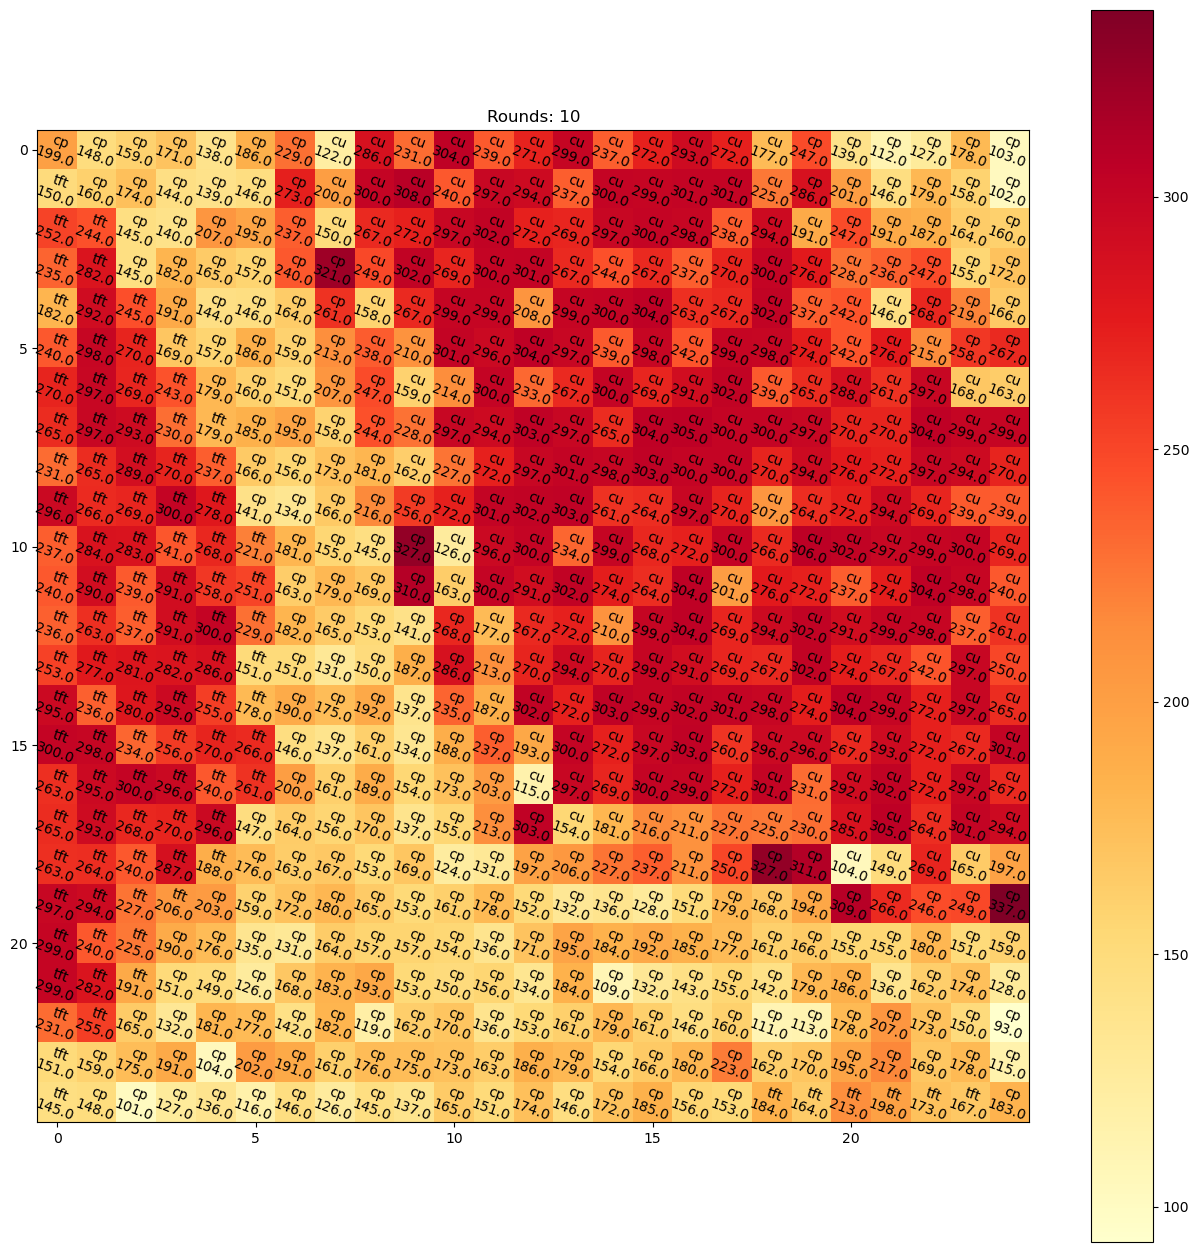

In [11]:
grid = GridArbiter(10, agents, error=0.01)#perlinGrid(25,25))
grid.generateRound()
grid.manageTournament(10)
grid.displayScores()